# Ejemplo regresion con LR, GLM y Ridge

El set de datos de los precios de las viviendas de Boston puede considerarse como el "Hola mundo" del análisis de regresión en machine learning. Pero antes de aplicarlarle cualquier librería de machine-learning vamos a intentar enfocar nuestra estimación de los precios de la vivienda con las herramientas vistas en las sesiones anteriores, es decir, utilizando pandas, numpy y statsmodels.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Leemos nuestro fichero de datos:

In [2]:
df = pd.read_excel('boston.xlsx')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Descripción de los campos:

| Titulo | Descripcion |
| --- | --- |
| CRIM | per capita crime rate by town |
| ZN | proportion of residential land zoned for lots over 25,000 sq.ft. |
| INDUS | proportion of non-retail business acres per town |
| CHAS | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| NOX | nitric oxides concentration (parts per 10 million) |
| RM | average number of rooms per dwelling |
| AGE | proportion of owner-occupied units built prior to 1940 |
| DIS | weighted distances to five Boston employment centres |
| RAD | index of accessibility to radial highways |
| TAX | full-value property-tax rate per \$10,000 |
| PTRATIO | pupil-teacher ratio by town |
| B | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| LSTAT | %lower status of the population |
| MEDV | Median value of owner-occupied homes in \$1000's |

## Primer paso: Mostrar los datos a estimar

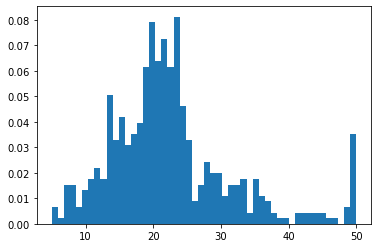

In [3]:
target = df['MEDV']
plt.hist(target, bins=50, density=True)
plt.show()

De la visualización, se aprecia que aproximadamente un 3% de las viviendas tienen precios superiores a \$48.000, que para evitar añadir ruido a nuestros modelos eliminados estos casos atípicos o punta.

In [4]:
df.drop(df[df.MEDV>48].index, inplace=True)
target = df['MEDV']

## PASO 2: Visualización de las correlaciones

Modo simple:

In [5]:
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.198981,0.407170,-0.064846,0.420876,-0.218482,0.354331,-0.382854,0.627115,0.583322,0.286402,-0.383986,0.461166,-0.459099
ZN,-0.198981,1.000000,-0.526899,-0.052834,-0.512743,0.304931,-0.563748,0.679512,-0.307319,-0.299538,-0.375958,0.175665,-0.420681,0.399635
INDUS,0.407170,-0.526899,1.000000,0.034385,0.767463,-0.406957,0.640229,-0.713422,0.595492,0.716163,0.381962,-0.362588,0.634059,-0.602902
CHAS,-0.064846,-0.052834,0.034385,1.000000,0.085418,0.050934,0.071193,-0.077902,-0.033502,-0.069235,-0.120705,0.042237,-0.008351,0.083166
NOX,0.420876,-0.512743,0.767463,0.085418,1.000000,-0.329185,0.726673,-0.767977,0.613141,0.668695,0.190256,-0.383449,0.613934,-0.539971
RM,-0.218482,0.304931,-0.406957,0.050934,-0.329185,1.000000,-0.276411,0.255459,-0.193375,-0.274987,-0.273411,0.116582,-0.608432,0.666680
AGE,0.354331,-0.563748,0.640229,0.071193,0.726673,-0.276411,1.000000,-0.742639,0.452586,0.500754,0.271870,-0.279323,0.640724,-0.510442
DIS,-0.382854,0.679512,-0.713422,-0.077902,-0.767977,0.255459,-0.742639,1.000000,-0.492713,-0.533814,-0.251472,0.299860,-0.539465,0.384847
RAD,0.627115,-0.307319,0.595492,-0.033502,0.613141,-0.193375,0.452586,-0.492713,1.000000,0.909244,0.455915,-0.451047,0.509594,-0.485107
TAX,0.583322,-0.299538,0.716163,-0.069235,0.668695,-0.274987,0.500754,-0.533814,0.909244,1.000000,0.448781,-0.447626,0.564049,-0.576997


Mapa de calor con la librería seaborn:

<AxesSubplot:>

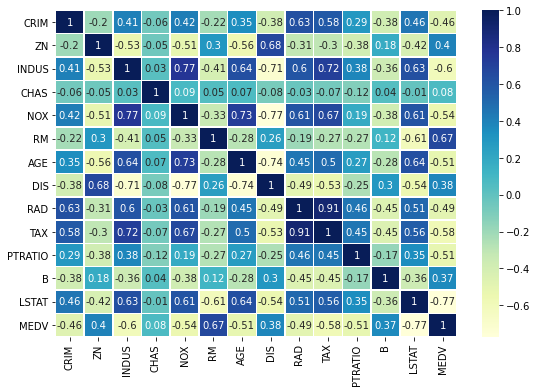

In [6]:
import seaborn as sns
corr = df.corr().round(2)
plt.subplots(figsize=(9, 6))
sns.heatmap(corr, cmap="YlGnBu", annot=True, linewidths=.5)

Este gráfico nos sirve para identificar la multicolinealidad entre variables. Por ejemplo, TAX (Impuestos)y RAD (acceso a radiales) tiene una correlacion del 0.91, por tanto, podriamos prescindir de una ellas para nuestro modelo.

En mi caso, voy a prescindir todas aquellas variables con una correlación menor al +/- 40%

In [7]:
df.drop(['ZN','CHAS','DIS','B'], axis=1 , inplace=True) 

## Paso 3: Analisis visual uni-variante:

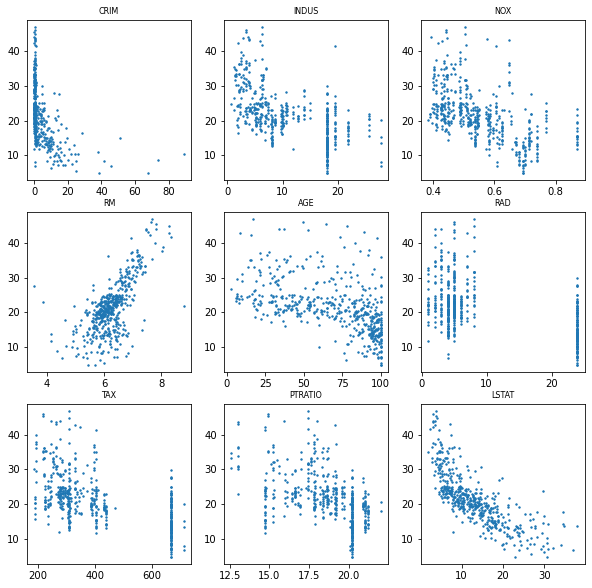

In [8]:
plt.figure(figsize=(10,10))
for index, columns in enumerate(df.columns[:9]):
    plt.subplot(331+index)
    plt.scatter(df[columns], target, s=2) 
    plt.title(columns, fontsize=8)
plt.show()

Se aprecian varias variables explicativas que pueden predecir el precio de una vivienda, la más llamativa por su linealidad y correlación positiva es el número medio de habitaciones (RM), donde se aprecia que a mayor numero de habitaciones mayor precio.

## Paso 4: Modelo lineal con stasmodels

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

nhab = df['RM']
nhab = sm.add_constant(nhab)
model = sm.OLS(target, nhab)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     388.0
Date:                Thu, 05 May 2022   Prob (F-statistic):           6.71e-64
Time:                        12:35:28   Log-Likelihood:                -1535.1
No. Observations:                 487   AIC:                             3074.
Df Residuals:                     485   BIC:                             3082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.0949      2.529    -11.108      0.0

In [10]:
print('Parametros de la recta:\n', result.params)

Parametros de la recta:
 const   -28.094916
RM        7.951235
dtype: float64


Los parámetros de nuestra recta serían $Precio = -28.09 + RM * 7.95$

Al ser una recta 2D es fácil graficarla:

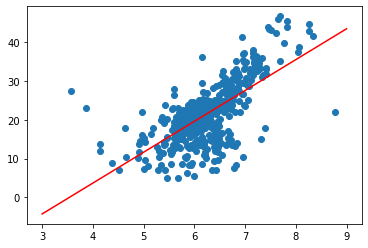

In [11]:
conts, slope = result.params
plt.scatter(df['RM'], target)
xfit = np.linspace(3, 9)
yfit = conts + slope * xfit
plt.plot(xfit, yfit, "r")

Para comparar los diferentes metodos de este ejercicio, voy a utilizar los residuos (diferencia entre la estimación y el real), concretamente el raíz del error cuadrático medio o RMSE (root-mean-square error), es decir, la raiz cuadrada de todos las desviaciones al cuadrado. 

Para ello, crearé un DataFrame llamado check al que añadiré los valores estimados y calcularé su residuo:

In [12]:
check = pd.DataFrame(data=target.values,columns=['REAL'])
check['PREDICT'] = result.predict(nhab).round(2)
check['RESIDUAL'] = ((check['REAL'] - check['PREDICT']) ** 2).round(2)
check.head()

,REAL,PREDICT,RESIDUAL
0,24.0,24.18,0.03
1,21.6,22.96,1.85
2,34.7,29.03,32.15
3,33.4,27.55,34.22
4,36.2,28.73,55.80


El cálculo del RMSE sería:

In [13]:
np.sqrt(check['RESIDUAL'].mean())

7.166787416991094

## Paso 5: GLM con stasmodels

In [14]:
formula = 'MEDV ~ CRIM + INDUS + NOX + RM + AGE + RAD + TAX + PTRATIO + LSTAT'

GLM con link poisson

In [15]:
import statsmodels.formula.api as smf

modelglm = smf.glm(formula=formula, data=df, family=sm.families.Poisson())
resultglm = modelglm.fit()
print(resultglm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   MEDV   No. Observations:                  487
Model:                            GLM   Df Residuals:                      477
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1321.1
Date:                Thu, 05 May 2022   Deviance:                       281.53
Time:                        12:35:28   Pearson chi2:                     294.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3799      0.213     15.846      0.0

Alimentamos nuestro DataFrame con la función **predict()** y calculamos el RMSE:

In [16]:
check['GLM_PREDICT'] = resultglm.predict(df).round(2)
check['GLM_RESIDUAL'] = ((check['REAL'] - check['GLM_PREDICT']) ** 2).round(2)
check.head()

,REAL,PREDICT,RESIDUAL,GLM_PREDICT,GLM_RESIDUAL
0,24.0,24.18,0.03,28.63,21.44
1,21.6,22.96,1.85,25.42,14.59
2,34.7,29.03,32.15,31.86,8.07
3,33.4,27.55,34.22,31.18,4.93
4,36.2,28.73,55.80,30.14,36.72


In [17]:
print('Residuo GLM: ', np.sqrt(check['GLM_RESIDUAL'].mean()))

Residuo GLM:  5.993985589560859


## Paso 6: Librería skit-learn 

Voy a utilizar librería de machine learning, aunque sin utilizar datos de entrenamiento y test (cross-validation)


In [18]:
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error

y = df['MEDV']
x = df.drop('MEDV', axis=1)

Modelos de regresión más utilizadas en scikit-learn:
* lm.LinearRegression()
* lm.Ridge()
* lm.Lasso()
* lm.SGDRegressor()
* lm.BayesianRidge()
* lm.TweedieRegressor()
* lm.ElasticNet()

En este caso, vamos a utilizar la regresión de crestas Ridge() (*Este método reduce los coeficientes introduciendo un término de penalización igual a la suma de coeficientes cuadrados por un coeficiente de penalización que va entre 0 y 1.*)

In [19]:
modelo = lm.Ridge()
resultado = modelo.fit(x, y)

In [20]:
check['ML_PREDICT'] = modelo.predict(x)
check['ML_RESIDUAL'] = ((check['REAL'] - check['ML_PREDICT']) ** 2).round(2)
check.head()

,REAL,PREDICT,RESIDUAL,GLM_PREDICT,GLM_RESIDUAL,ML_PREDICT,ML_RESIDUAL
0,24.0,24.18,0.03,28.63,21.44,28.548168,20.69
1,21.6,22.96,1.85,25.42,14.59,25.576154,15.81
2,34.7,29.03,32.15,31.86,8.07,30.365496,18.79
3,33.4,27.55,34.22,31.18,4.93,29.891968,12.31
4,36.2,28.73,55.80,30.14,36.72,29.449883,45.56


In [21]:
print('Residio: ', np.sqrt(check['ML_RESIDUAL'].mean()))
#mse = mean_squared_error(check['REAL'], check['ML_PREDICT'])**0.5
#print(mse)

Residio:  3.8784112626140166


In [22]:
rmse = np.sqrt(mean_squared_error(check['REAL'], check['ML_PREDICT']))
print(rmse)

3.8784397162159676


La regresión Ridge posee con diferencia un menor error de previsión, y ofrece mejores
resultados que las regresiones anteriores (lineal clásica y GLM).

¿Es posible bajar más el error? Si, scikit posee otras funciones con regresiones SGD (Stochastic
Gradient Descent) o polinominales (varios grados de linealidad) muy eficaces que
pueden reducir considerablemente error (en este ejemplo incluso con valores RMSE cercanos
a 1), aunque no conseguiremos fórmulas de estimación muy fiables ya el módelo, conforme puede plantearse, existiría sobreajustes o overfitting.

Para validar dichas regresiones hace falta utilizar la validación cruzada, es decir, entrenar
el modelo con p.ej. el 75% de los datos, y ver cómo de fiable es estimando el 25% restante,
técnica conocida como validación cruzada o Leave-One-Out (Dejar uno fuera).